# Assignment 1: Fine-Grained Bird Classification

## Setup and Configuration

### Import Required Libraries

In [75]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix


In [48]:
import multiprocessing
multiprocessing.set_start_method('fork', force=True)

### Configuration and Reproducibility Setup

In [72]:
# Training configuration
CONFIG = {
    'RANDOM_SEED': 42,
    'IMAGE_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'LEARNING_RATE': 0.001,
    'NUM_CLASSES': 5,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'MODEL_SAVE_PATH': './models/best_bird_cnn.pt',
    'CHECKPOINT_DIR': './models/checkpoints/',
    'EARLY_STOPPING_PATIENCE': 8,
    'SAVE_CHECKPOINTS': True
}

os.makedirs('./models', exist_ok=True)
os.makedirs('./models/checkpoints', exist_ok=True)

print(f"Device: {CONFIG['DEVICE']}")
print(f"Configuration: {CONFIG}")

Device: cpu
Configuration: {'RANDOM_SEED': 42, 'IMAGE_SIZE': (224, 224), 'BATCH_SIZE': 32, 'EPOCHS': 50, 'LEARNING_RATE': 0.001, 'NUM_CLASSES': 5, 'DEVICE': 'cpu', 'MODEL_SAVE_PATH': './models/best_bird_cnn.pt', 'CHECKPOINT_DIR': './models/checkpoints/', 'EARLY_STOPPING_PATIENCE': 8, 'SAVE_CHECKPOINTS': True}


In [4]:
# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['RANDOM_SEED'])

## Data Exploration and Analysis

### Dataset Paths and Config

In [5]:
DATA_ROOT = './CUB_200_2011'
IMAGES_PATH = os.path.join(DATA_ROOT, 'images')
TRAIN_TEST_SPLIT_PATH = os.path.join(DATA_ROOT, 'train_test_split.txt')
CLASSES_PATH = os.path.join(DATA_ROOT, 'classes.txt')
IMAGE_CLASS_LABELS_PATH = os.path.join(DATA_ROOT, 'image_class_labels.txt')
IMAGES_TXT_PATH = os.path.join(DATA_ROOT, 'images.txt')

In [6]:
TARGET_CLASSES = [
    'Black_footed_Albatross',
    'Red_faced_Cormorant', 
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_breasted_Chat'
]

### Basic Statistics Analysis

In [16]:
def load_dataset_info():
    images = pd.read_csv(IMAGES_TXT_PATH, sep=' ', header=None, names=['image_id', 'image_name'])
    labels = pd.read_csv(IMAGE_CLASS_LABELS_PATH, sep=' ', header=None, names=['image_id', 'class_id'])
    split = pd.read_csv(TRAIN_TEST_SPLIT_PATH, sep=' ', header=None, names=['image_id', 'is_train'])
    classes = pd.read_csv(CLASSES_PATH, sep=' ', header=None, names=['class_id', 'class_name'])
    
    return images, labels, split, classes

def parse_class_mapping(classes):
    class_to_id = {}
    id_to_class = {}
    
    for _, row in classes.iterrows():
        class_id = row['class_id']
        class_name = row['class_name'].split('.')[1]
        class_to_id[class_name] = class_id
        id_to_class[class_id] = class_name
    
    return class_to_id, id_to_class

def get_target_data(images, labels, split, class_to_id):
    target_ids = [class_to_id[name] for name in TARGET_CLASSES if name in class_to_id]
    
    data = images.merge(labels, on='image_id').merge(split, on='image_id')
    target_data = data[data['class_id'].isin(target_ids)].copy()
    
    target_data['class_label'] = target_data['class_id'].map({
        target_ids[i]: i for i in range(len(target_ids))
    })
    
    return target_data, target_ids

In [17]:
def explore_dataset():
    images, labels, split, classes = load_dataset_info()
    class_to_id, id_to_class = parse_class_mapping(classes)
    target_data, target_ids = get_target_data(images, labels, split, class_to_id)
    
    print(f"Total images: {len(images)}")
    print(f"Target classes found: {len(target_ids)}")
    print(f"Target images: {len(target_data)}")
    
    return target_data, class_to_id, id_to_class

In [32]:
def analyze_basic_stats(target_data):
    class_counts = target_data['class_label'].value_counts().sort_index()
    train_counts = target_data[target_data['is_train']==1]['class_label'].value_counts().sort_index()
    test_counts = target_data[target_data['is_train']==0]['class_label'].value_counts().sort_index()
    
    stats_df = pd.DataFrame({
        'Total': class_counts,
        'Train': train_counts,
        'Test': test_counts
    }).fillna(0).astype(int)
    
    return stats_df

In [33]:
target_data, class_to_id, id_to_class = explore_dataset()
stats_df = analyze_basic_stats(target_data)

Total images: 11788
Target classes found: 5
Target images: 289


### Data Distribution Analysis and Visualization

In [20]:
def analyze_data_balance(stats_df):
    total_counts = stats_df['Total']
    train_ratios = stats_df['Train'] / stats_df['Total'] * 100
    
    balance_metrics = {
        'imbalance_ratio': total_counts.max() / total_counts.min(),
        'sample_range': (total_counts.min(), total_counts.max()),
        'mean_train_ratio': train_ratios.mean(),
        'train_ratio_std': train_ratios.std()
    }
    
    print(f"Imbalance Ratio: {balance_metrics['imbalance_ratio']:.2f}")
    print(f"Sample Range: {balance_metrics['sample_range'][0]} - {balance_metrics['sample_range'][1]}")
    print(f"Train Ratio: {balance_metrics['mean_train_ratio']:.1f}% ± {balance_metrics['train_ratio_std']:.1f}%")
    
    return balance_metrics

In [27]:
def plot_distribution(stats_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    class_names = [name.replace('_', ' ') for name in TARGET_CLASSES]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    
    bars = axes[0].bar(range(len(class_names)), stats_df['Total'], color=colors)
    axes[0].set_title('Sample Distribution by Class')
    axes[0].set_xticks(range(len(class_names)))
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].set_ylabel('Count')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 1, 
                    f'{int(height)}', ha='center', va='bottom')
    
    stats_df[['Train', 'Test']].plot(kind='bar', ax=axes[1], color=['lightblue', 'lightcoral'])
    axes[1].set_title('Train/Test Split')
    axes[1].set_ylabel('Count')
    axes[1].set_xticklabels(range(len(class_names)), rotation=0)
    axes[1].legend()
    
    plt.tight_layout()
    return fig

In [28]:
def distribution_analysis(stats_df):
    print("=== Data Distribution Analysis ===")
    print(stats_df)
    print()
    
    balance_metrics = analyze_data_balance(stats_df)
    fig = plot_distribution(stats_df)
    
    plt.show()
    return balance_metrics

In [29]:
balance_metrics = distribution_analysis(stats_df)
balance_metrics

=== Data Distribution Analysis ===
             Total  Train  Test
class_label                    
0               60     30    30
1               52     30    22
2               60     30    30
3               58     30    28
4               59     30    29

Imbalance Ratio: 1.15
Sample Range: 52 - 60
Train Ratio: 52.1% ± 3.2%


{'imbalance_ratio': 1.1538461538461537,
 'sample_range': (52, 60),
 'mean_train_ratio': np.float64(52.05278065009215),
 'train_ratio_std': 3.232371098789766}

### Image Feature Analysis

In [34]:
def analyze_image_sizes(target_data):
    sizes = []
    aspects = []
    
    for _, row in target_data.iterrows():
        img_path = os.path.join(IMAGES_PATH, row['image_name'])
        if os.path.exists(img_path):
            img = Image.open(img_path)
            w, h = img.size
            sizes.append((w, h))
            aspects.append(w/h)
    
    sizes_array = np.array(sizes)
    size_stats = {
        'width_range': (sizes_array[:, 0].min(), sizes_array[:, 0].max()),
        'height_range': (sizes_array[:, 1].min(), sizes_array[:, 1].max()),
        'mean_size': (sizes_array[:, 0].mean(), sizes_array[:, 1].mean()),
        'aspect_ratio_range': (min(aspects), max(aspects)),
        'mean_aspect': np.mean(aspects)
    }
    
    print(f"Width: {size_stats['width_range'][0]:.0f} - {size_stats['width_range'][1]:.0f}")
    print(f"Height: {size_stats['height_range'][0]:.0f} - {size_stats['height_range'][1]:.0f}")
    print(f"Mean Size: {size_stats['mean_size'][0]:.0f} x {size_stats['mean_size'][1]:.0f}")
    print(f"Aspect Ratio: {size_stats['aspect_ratio_range'][0]:.2f} - {size_stats['aspect_ratio_range'][1]:.2f}")
    
    return sizes_array, aspects, size_stats

In [35]:
def visualize_samples(target_data):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    
    for class_idx in range(5):
        class_data = target_data[target_data['class_label'] == class_idx].sample(n=5, random_state=42)
        
        for i, (_, row) in enumerate(class_data.iterrows()):
            img_path = os.path.join(IMAGES_PATH, row['image_name'])
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[class_idx, i].imshow(img)
                axes[class_idx, i].axis('off')
                if i == 0:
                    axes[class_idx, i].set_title(TARGET_CLASSES[class_idx].replace('_', ' '), 
                                                fontsize=10, loc='left')
    
    plt.suptitle('Sample Images per Class (5 samples each)', fontsize=14)
    plt.tight_layout()
    return fig

In [36]:
def analyze_image_quality(target_data):
    brightness_stats = []
    size_variance = []
    
    for class_idx in range(5):
        class_data = target_data[target_data['class_label'] == class_idx].sample(n=20, random_state=42)
        class_brightness = []
        class_sizes = []
        
        for _, row in class_data.iterrows():
            img_path = os.path.join(IMAGES_PATH, row['image_name'])
            if os.path.exists(img_path):
                img = np.array(Image.open(img_path))
                if len(img.shape) == 3:
                    brightness = img.mean()
                    class_brightness.append(brightness)
                    class_sizes.append(img.shape[0] * img.shape[1])
        
        brightness_stats.append(np.mean(class_brightness))
        size_variance.append(np.std(class_sizes))
    
    quality_stats = pd.DataFrame({
        'Class': TARGET_CLASSES,
        'Mean_Brightness': brightness_stats,
        'Size_Variance': size_variance
    })
    
    print("Image Quality Analysis:")
    print(quality_stats.round(2))
    
    return quality_stats

In [37]:
def plot_size_distribution(sizes_array, aspects):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].scatter(sizes_array[:, 0], sizes_array[:, 1], alpha=0.6, s=20)
    axes[0].set_xlabel('Width')
    axes[0].set_ylabel('Height')
    axes[0].set_title('Size Distribution')
    axes[0].axhline(y=224, color='red', linestyle='--', alpha=0.7, label='Target Size')
    axes[0].axvline(x=224, color='red', linestyle='--', alpha=0.7)
    axes[0].legend()
    
    axes[1].hist(aspects, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Aspect Ratio (W/H)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Aspect Ratio Distribution')
    axes[1].axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Square')
    axes[1].legend()
    
    widths = sizes_array[:, 0]
    heights = sizes_array[:, 1]
    axes[2].hist([widths, heights], bins=30, alpha=0.7, label=['Width', 'Height'], color=['blue', 'orange'])
    axes[2].set_xlabel('Pixels')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Width/Height Distribution')
    axes[2].axvline(x=224, color='red', linestyle='--', alpha=0.7, label='Target')
    axes[2].legend()
    
    plt.tight_layout()
    return fig

In [38]:
def image_analysis(target_data):
    print("=== Image Feature Analysis ===")
    
    sizes_array, aspects, size_stats = analyze_image_sizes(target_data)
    quality_stats = analyze_image_quality(target_data)
    
    fig1 = visualize_samples(target_data)
    fig2 = plot_size_distribution(sizes_array, aspects)
    
    plt.show()
    
    return size_stats, quality_stats, sizes_array, aspects

In [39]:
size_stats, quality_stats, sizes_array, aspects = image_analysis(target_data)

=== Image Feature Analysis ===
Width: 170 - 500
Height: 136 - 500
Mean Size: 446 x 392
Aspect Ratio: 0.38 - 2.17
Image Quality Analysis:
                    Class  Mean_Brightness  Size_Variance
0  Black_footed_Albatross           143.77       50620.22
1     Red_faced_Cormorant           121.57       54178.89
2                Bobolink           129.52       14591.18
3          Lazuli_Bunting           131.26       35141.09
4    Yellow_breasted_Chat           117.55       16616.63


### EDA Summary
#### Dataset Balance Analysis

- Excellent class balance: Imbalance ratio of 1.15 (52-60 samples per class) requires no special handling
- Consistent train/test split: Fixed 30 training samples per class, test samples range 22-30
- Stable split ratio: 52.1% ± 3.2% training ratio indicates consistent official splitting strategy

#### Image Characteristics

- Significant size variation: Width ranges 170-500px, height ranges 136-500px
- Large original images: Mean size 446×392px, substantially larger than target 224×224px
- Diverse aspect ratios: Range 0.38-2.17, indicating both tall-narrow and wide-flat images
- Quality differences across classes: Brightness varies 117-143, size variance differs significantly (14,591-54,179)

#### Key Findings

- Red_faced_Cormorant shows highest size variance (54,179) and lowest sample count (52)
- Bobolink demonstrates most consistent image sizes (variance: 14,591)
- Most images exceed target dimensions requiring downsampling
- Aspect ratio distribution centers around 1.0-1.5 (slightly horizontal)

## Data Preprocessing

### Define Image Transforms

In [63]:
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        p_left, p_top = (max_wh - w) // 2, (max_wh - h) // 2
        p_right, p_bottom = max_wh - w - p_left, max_wh - h - p_top
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')

train_transform = transforms.Compose([
    SquarePad(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define Bird Dataset

In [64]:
class BirdDataset(Dataset):
    def __init__(self, target_data, images_path, transform=None, is_train=True):
        if is_train:
            self.data = target_data[target_data['is_train'] == 1].reset_index(drop=True)
        else:
            self.data = target_data[target_data['is_train'] == 0].reset_index(drop=True)
        
        self.images_path = images_path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.images_path, row['image_name'])
        
        image = Image.open(img_path).convert('RGB')
        label = row['class_label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, row['image_name']

In [65]:
train_dataset = BirdDataset(target_data, IMAGES_PATH, train_transform, is_train=True)
test_dataset = BirdDataset(target_data, IMAGES_PATH, test_transform, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 150
Test samples: 139


### Preprocessing Validation and Visualization

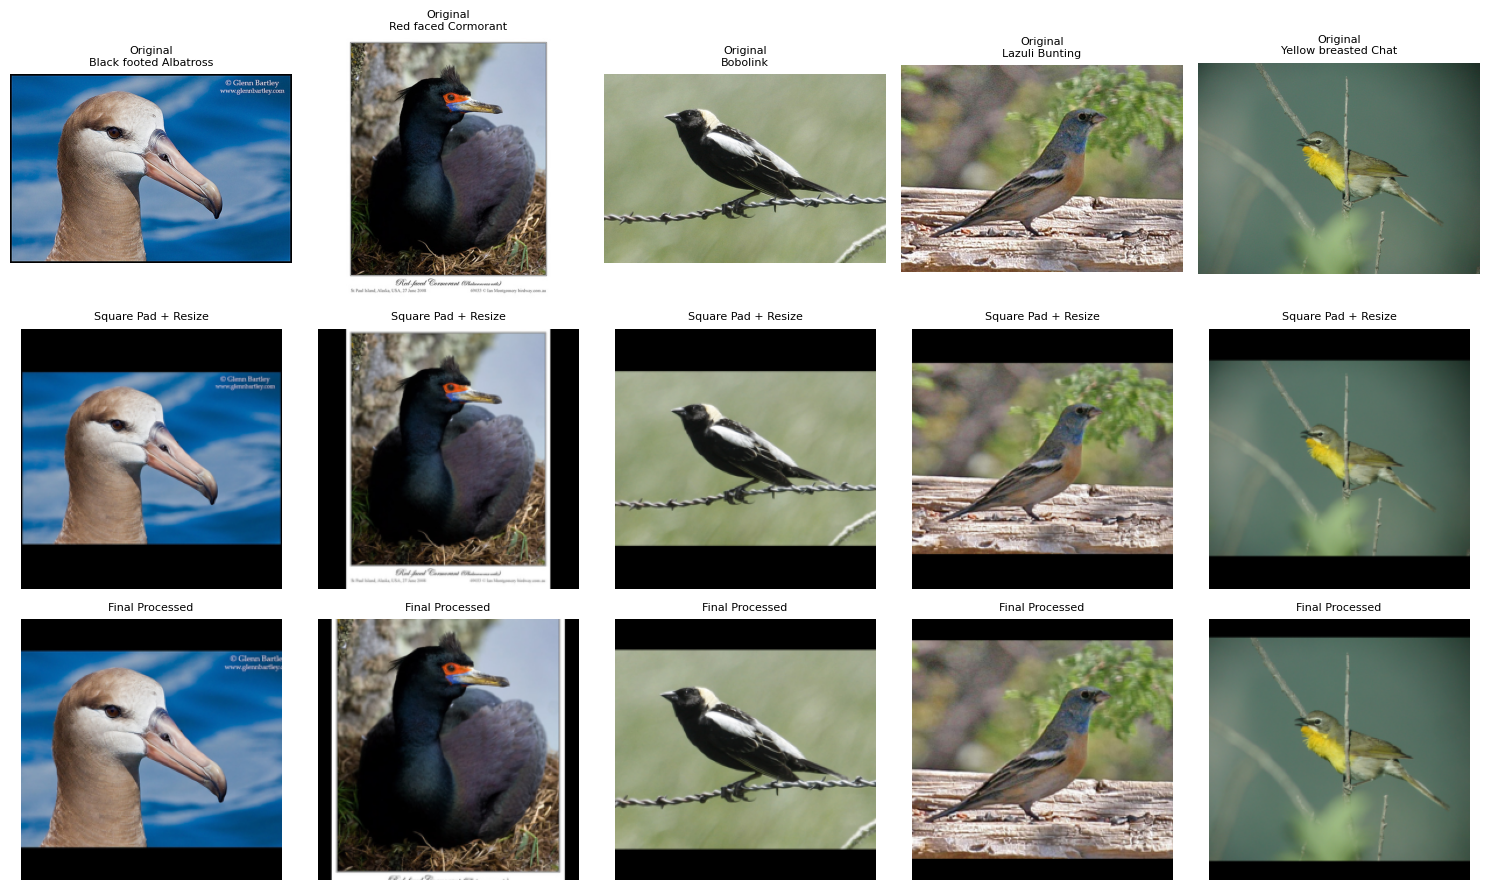

In [66]:
def visualize_preprocessing():
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    
    for class_idx in range(5):
        class_samples = target_data[target_data['class_label'] == class_idx].sample(n=1, random_state=42)
        sample_row = class_samples.iloc[0]
        img_path = os.path.join(IMAGES_PATH, sample_row['image_name'])
        
        original_img = Image.open(img_path).convert('RGB')
        
        axes[0, class_idx].imshow(original_img)
        axes[0, class_idx].set_title(f"Original\n{TARGET_CLASSES[class_idx].replace('_', ' ')}", fontsize=8)
        axes[0, class_idx].axis('off')
        
        square_padded = SquarePad()(original_img)
        resized_only = transforms.Resize((224, 224))(square_padded)
        axes[1, class_idx].imshow(resized_only)
        axes[1, class_idx].set_title("Square Pad + Resize", fontsize=8)
        axes[1, class_idx].axis('off')
        
        test_processed = test_transform(original_img)
        test_denorm = test_processed * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        test_denorm = torch.clamp(test_denorm, 0, 1)
        axes[2, class_idx].imshow(test_denorm.permute(1, 2, 0))
        axes[2, class_idx].set_title("Final Processed", fontsize=8)
        axes[2, class_idx].axis('off')
    
    plt.tight_layout()
    return fig

fig = visualize_preprocessing()
plt.show()

### Batch Processing and Statistics

In [67]:
def analyze_processed_data():
    sample_batch = next(iter(train_loader))
    images, labels, _ = sample_batch
    
    print(f"Batch shape: {images.shape}")
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Image mean: {images.mean(dim=[0,2,3])}")
    print(f"Image std: {images.std(dim=[0,2,3])}")
    
    label_counts = torch.bincount(labels)
    print(f"Labels in batch: {label_counts}")

analyze_processed_data()

Batch shape: torch.Size([32, 3, 224, 224])
Image range: [-2.118, 2.640]
Image mean: tensor([-0.5169, -0.2824, -0.2917])
Image std: tensor([1.2259, 1.2694, 1.2954])
Labels in batch: tensor([6, 8, 6, 6, 6])


## Part 1: CNN for Fine-Grained Bird Classification

- Model architecture: 3-5 blocks (each with 2-3 conv layers + pooling)
- Followed by fully-connected layers
- All images resized to 224x224 pixels
- Freedom in kernel size, activation functions, pooling type
- Use official train/test split

### Model Architecture Design

In [70]:
class BirdCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BirdCNN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Model Architecture Summary and Visualization

In [71]:
model = BirdCNN(num_classes=5).to(CONFIG['DEVICE'])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)

print(f"Model Parameters: {total_params:,}")
print(f"Device: {CONFIG['DEVICE']}")

dummy_input = torch.randn(1, 3, 224, 224).to(CONFIG['DEVICE'])
with torch.no_grad():
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")

Model Parameters: 5,412,421
Device: cpu
Output shape: torch.Size([1, 5])


### Model Training

#### Training Setup

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels, _ in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

#### Training Loop

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)
        
        scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if CONFIG['SAVE_CHECKPOINTS'] and (epoch + 1) % 10 == 0:
            checkpoint_path = f"{CONFIG['CHECKPOINT_DIR']}checkpoint_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'scheduler_state_dict': scheduler.state_dict()
            }, checkpoint_path)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
            print('-' * 50)
        
        if patience_counter >= CONFIG['EARLY_STOPPING_PATIENCE']:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    model.load_state_dict(best_model_state)
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs,
        'best_val_acc': best_val_acc
    }
    
    return model, history

model, history = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, CONFIG['EPOCHS'], CONFIG['DEVICE'])

#### Training Visualization

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    return fig

fig = plot_training_history(history)
plt.show()

print(f"Best Validation Accuracy: {history['best_val_acc']:.2f}%")

#### Save Best Model

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': history['best_val_acc'],
    'config': CONFIG,
    'history': history
}, CONFIG['MODEL_SAVE_PATH'])

## Model Evaluation and Performance Analysis

In [ ]:
# Evaluation functions
def evaluate_model(model, test_loader, device):
    # Implement evaluation
    pass

def calculate_metrics(y_true, y_pred, class_names):
    # Calculate all required metrics
    pass

In [ ]:
# Evaluate on test set


### Performance Results Table

**Part 1 Results:**

| Classes | Accuracy | Precision | Recall | F1 | F1-micro | F1-macro | F1-weighted |
|---------|----------|-----------|--------|----|---------|---------|-----------|
| Black_footed_Albatross | - | - | - | - | - | - | - |
| Red_faced_Cormorant | - | - | - | - | - | - | - |
| Bobolink | - | - | - | - | - | - | - |
| Lazuli_Bunting | - | - | - | - | - | - | - |
| Yellow_breasted_Chat | - | - | - | - | - | - | - |
| **Overall (Average)** | - | - | - | - | - | - | - |

In [ ]:
# Generate and display performance table


---
# Part 2: Cost-Sensitive Learning [15 marks]

## Problem Description
In real-world scenarios, not all misclassifications are equal. We need to minimize total misclassification cost rather than simply maximizing accuracy.

## Misclassification Cost Matrix

| Labeled as \ Classified as | Albatross | Cormorant | Bobolink | Bunting | Chat |
|---------------------------|-----------|-----------|----------|---------|------|
| **Albatross** | 0 | 4 | 10 | 12 | 11 |
| **Cormorant** | 3 | 0 | 11 | 13 | 12 |
| **Bobolink** | 9 | 10 | 0 | 2 | 3 |
| **Bunting** | 13 | 12 | 2 | 0 | 4 |
| **Chat** | 12 | 11 | 3 | 4 | 0 |

**Example**: If test set has 3 images (Albatross, Bobolink, Bunting) and model predicts all as 'Bobolink', average cost = (10+0+2)/3 = 4.0

In [ ]:
# Define misclassification cost matrix
COST_MATRIX = np.array([
    [0,  4,  10, 12, 11],  # Albatross
    [3,  0,  11, 13, 12],  # Cormorant  
    [9,  10, 0,  2,  3],   # Bobolink
    [13, 12, 2,  0,  4],   # Bunting
    [12, 11, 3,  4,  0]    # Chat
])

print("Misclassification Cost Matrix:")
print(COST_MATRIX)

## Cost-Sensitive Learning Implementation

### Approach: [Describe your chosen approach here]
- Method 1: Weighted Loss Function
- Method 2: Class Weights
- Method 3: Threshold Adjustment
- Method 4: Custom Loss Function

In [ ]:
# Implement cost-sensitive learning approach

# Option 1: Custom loss function based on cost matrix
class CostSensitiveLoss(nn.Module):
    def __init__(self, cost_matrix):
        super(CostSensitiveLoss, self).__init__()
        # Implement cost-sensitive loss
        pass
    
    def forward(self, outputs, targets):
        # Calculate cost-sensitive loss
        pass

# Option 2: Calculate class weights from cost matrix
def calculate_class_weights(cost_matrix):
    # Calculate appropriate class weights
    pass

In [ ]:
# Create and train cost-sensitive model
# This can be a modification of the original model or a new training approach


In [ ]:
# Cost evaluation functions
def calculate_misclassification_cost(y_true, y_pred, cost_matrix):
    # Calculate average misclassification cost
    pass

def evaluate_cost_sensitive_model(model, test_loader, cost_matrix, device):
    # Evaluate model with cost considerations
    pass

In [ ]:
# Evaluate cost-sensitive model


## Part 2 Results Analysis

### Modifications Made:
[Describe the modifications you made to your model or training procedure]

### Cost Comparison:
- **Original Model Average Cost**: [Fill in]
- **Cost-Sensitive Model Average Cost**: [Fill in]
- **Improvement**: [Fill in] (Lower is better)

### Discussion:
[Explain whether your approach led to improvement and why]

---
# Part 3: Model Deployment for Competition [20 marks]

## Requirements:
- Create a `test_single` function that takes image file path as input
- Return single integer (0-4) corresponding to predicted class
- Must be in a standalone cell
- Ranking based on average misclassification cost on hidden test set

In [ ]:
# Prepare final model for deployment
# Load the best cost-sensitive model


## Final Deployment Function
**Note**: This cell contains the standalone `test_single` function for competition evaluation.

In [ ]:
# STANDALONE DEPLOYMENT FUNCTION - DO NOT MODIFY THIS CELL STRUCTURE

def test_single(image_path):
    """
    Test function for single image prediction
    
    Args:
        image_path (str): Path to the image file (e.g., 'img_test.jpg')
    
    Returns:
        int: Predicted class (0: Albatross, 1: Cormorant, 2: Bobolink, 3: Bunting, 4: Chat)
    """
    
    # Implementation here
    # 1. Load and preprocess the image
    # 2. Run inference with the trained model
    # 3. Return predicted class as integer
    
    pass

# Test the function
# test_result = test_single('path/to/test/image.jpg')
# print(f"Predicted class: {test_result}")

## Function Testing and Validation

In [ ]:
# Test the deployment function with sample images


---
# Final Summary and Submission Checklist

## Part 1 Deliverables ✓
- [ ] Clear model architecture description
- [ ] Performance table with all metrics
- [ ] Reproducible code with seeds set

## Part 2 Deliverables ✓
- [ ] Description of modifications for cost-sensitive learning
- [ ] Average misclassification cost results
- [ ] Improvement analysis and discussion

## Part 3 Deliverables ✓
- [ ] Standalone `test_single` function
- [ ] Function returns integer (0-4)
- [ ] Function accepts file path as input
- [ ] Error-free execution

## Technical Requirements ✓
- [ ] All training outputs retained
- [ ] Jupyter notebook with all artifacts
- [ ] Reproducible with same .ipynb file
- [ ] Random seeds set for reproducibility

---
**Assignment completed. Ready for submission.**